In [53]:
import json
import intervaltree

In [54]:
def read_CD(path):
    all_annots = []
    primary_annot = None
    sub_header = None
    top_header = None
    for line_no, line in enumerate(open(path)):
        line = line.rstrip()
        if line:
            if line_no == 0:
                top_header = line.split(",")
            if line_no > 0:
                if "Checked" in line:
                    if sub_header is None:
                        sub_header = line.split(",")
                else:
                    data = line.split(",")
                    if data[-1] == data[-2] == data[-3]:
                        alt_annot = dict(zip(sub_header, data))
                        primary_annot['alternatives'].append(alt_annot)
                    else:
                        if primary_annot:
                            if primary_annot["MS2"] != "No MS2":
                                all_annots.append(primary_annot)
                        primary_annot = dict(zip(top_header, data))
                        primary_annot['alternatives'] = []
    if primary_annot:
        if primary_annot["MS2"] != "No MS2":
            all_annots.append(primary_annot)
    return all_annots

In [55]:
def read_pcpfm(path):
    return json.load(open(path))

In [56]:
def map_CD_annots(cd_annots, pcpfm_annots, mz_err=10, rt_err=30):
    mz_tree, rt_tree = intervaltree.IntervalTree(), intervaltree.IntervalTree()
    khipu_to_features, features_to_khipu = {}, {}
    for kp_id, kp in pcpfm_annots.items():
        for peak in kp["MS1_pseudo_Spectra"]:
            id = peak['id_number']
            features_to_khipu[id] = kp_id
            if kp_id in khipu_to_features:
                khipu_to_features[kp_id].append(id)
            else:
                khipu_to_features[kp_id] = [id]
            mz, rtime = peak['mz'], peak['rtime']
            mz_tree.addi(mz - (mz / 1e6 * mz_err) - .0001, mz + (mz / 1e6 * mz_err) + .0001, id)
            rt_tree.addi(rtime - rt_err, rtime + rt_err, id)            
    for cd_annot in cd_annots:
        cd_annot['mapped_to'] = set()
        if cd_annot['Name']:
            try:
                mz = float(cd_annot['m/z'])
                rt = float(cd_annot['RT [min]']) * 60
                mz_matches = [x.data for x in mz_tree.at(mz)]
                rt_matches = [x.data for x in rt_tree.at(rt)]
                for match in [x for x in mz_matches if x in rt_matches]:
                    for khipu_feature in khipu_to_features[features_to_khipu[match]]:
                        cd_annot['mapped_to'].add(khipu_feature)
            except:
                print("Problem")
    return cd_annots

In [57]:
def find_best(PCPFM_annots):
    for kp_id, kp in PCPFM_annots.items():
        if "MS2_Spectra" in kp:
            for MS2 in kp["MS2_Spectra"]:
                for annotation in MS2['annotations']:
                    if annotation['matched_peaks'] > 10 and annotation["msms_score"] > .95:
                        print(kp_id, annotation)


In [72]:
def mirror_plot(kp_id, PCPFM_annots):
    import matplotlib.pyplot as plt
    kp = PCPFM_annots[kp_id]
    if "MS2_Spectra" in kp:
        for MS2 in kp["MS2_Spectra"]:
            for annotation in MS2['annotations']:
                if annotation['matched_peaks'] > 10 and annotation["msms_score"] > .9:
                    for mz, intensity in annotation['db_spectrum']:
                        plt.plot((mz, mz), (0, -1 * intensity), c='k')
                    for mz, intensity in zip(MS2['list_mz'], MS2['list_intensity']):
                        plt.plot((mz, mz), (0, intensity), c='r')
                    plt.title(annotation['reference_id'])
                    break
                    
    plt.xlabel("m/z")
    plt.ylabel("Abundance")
    plt.show()
    for mz, intensity in zip(MS2['list_mz'], MS2['list_intensity']):
        plt.plot((mz, mz), (0, intensity), c='r')
    plt.show()
    for mz, intensity in annotation['db_spectrum']:
        plt.plot((mz, mz), (0, 1 * intensity), c='k')
    plt.show()



Problem
Problem
9902
976 3009
Shared Annotations:  651


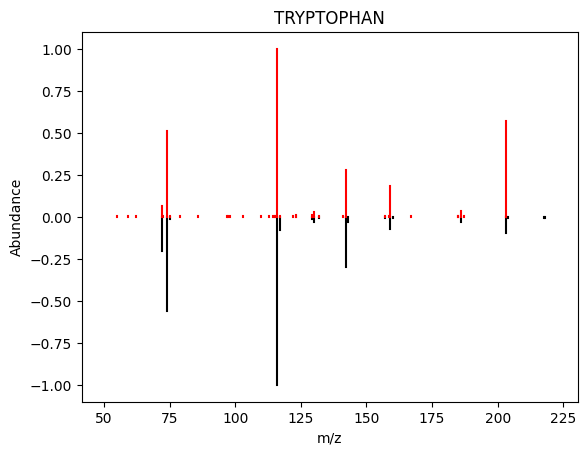

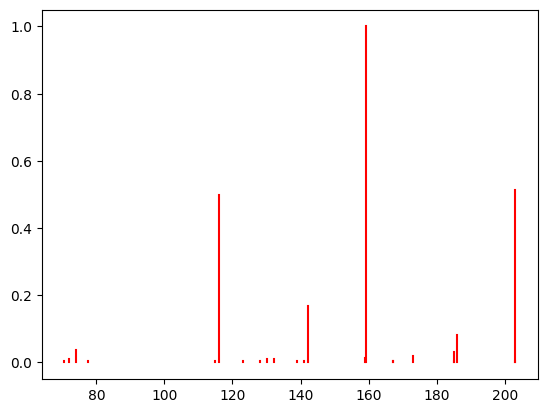

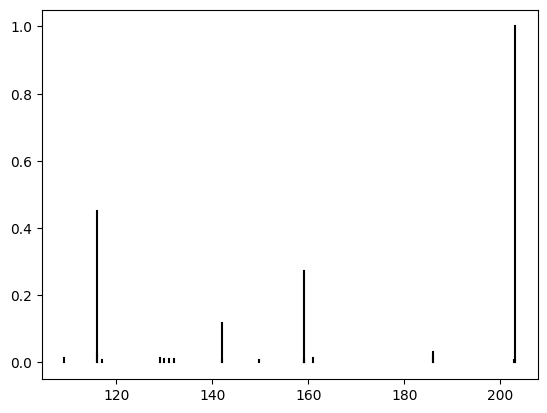

In [73]:
CD_annots = read_CD("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/manuscript_notebooks/pcpfm_vs_cd/CD_MoNA_RP_neg.csv")
PCPFM_annots = read_pcpfm("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/Plasma_Lipidomics/annotations/MoNA_HMDB_LMSD_annotated_for_analysis_empCpds.json")
CD_annots = map_CD_annots(CD_annots, PCPFM_annots)

all_CD_annot_cpds = set()
all_PCPFM_annot_cpds = set()

for cd_annot in CD_annots:
    for feature in cd_annot["mapped_to"]:
        all_CD_annot_cpds.add(cd_annot["Name"] + "_" + feature)
x=0
for kp_id, kp in PCPFM_annots.items():
    if "MS2_Spectra" in kp:
        for MS2 in kp["MS2_Spectra"]:
            all_annotations = [(annotation, annotation["msms_score"]) for annotation in MS2["annotations"]]
            all_annotations = sorted(all_annotations, key=lambda x: -x[1])
            all_annotations = [x[0] for x in all_annotations[:10]]
            for annotation in all_annotations:
                for peak in kp["MS1_pseudo_Spectra"]:
                    id = peak['id_number']
                    x+=1
                    all_PCPFM_annot_cpds.add(annotation['reference_id'] + "_" + id)
print(x)

print(len(all_CD_annot_cpds), len(all_PCPFM_annot_cpds))
CD_in_PCPFM = all_CD_annot_cpds.intersection(all_PCPFM_annot_cpds)
print("Shared Annotations: ", len(CD_in_PCPFM))

mirror_plot("kp988_204.0898", PCPFM_annots)


Problem
Problem
Problem
Problem
1115 3874
Shared Annotations:  789


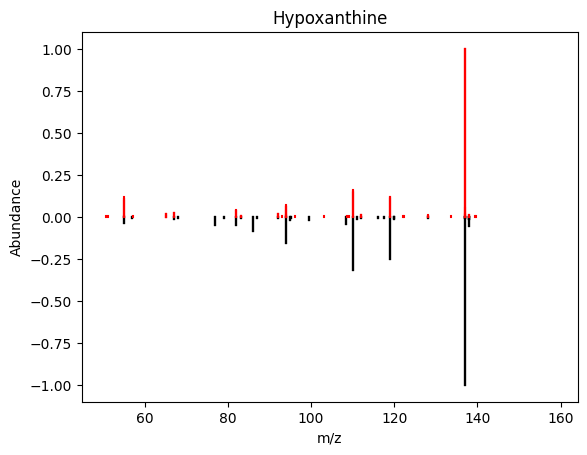

In [60]:

CD_annots = read_CD("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/manuscript_notebooks/pcpfm_vs_cd/CD_MoNA_HILIC_pos.csv")
PCPFM_annots = read_pcpfm("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/Plasma_Metabolomics_HILIC_pos/annotations/MoNA_HMDB_LMSD_annotated_for_analysis_empCpds.json")
CD_annots = map_CD_annots(CD_annots, PCPFM_annots, mz_err=10)


all_CD_annot_cpds = set()
all_PCPFM_annot_cpds = set()

for cd_annot in CD_annots:
    for feature in cd_annot["mapped_to"]:
        all_CD_annot_cpds.add(cd_annot["Name"] + "_" + feature)
x=0
for kp_id, kp in PCPFM_annots.items():
    if "MS2_Spectra" in kp:
        for MS2 in kp["MS2_Spectra"]:
            all_annotations = [(annotation, annotation["msms_score"]) for annotation in MS2["annotations"]]
            all_annotations = sorted(all_annotations, key=lambda x: -x[1])
            all_annotations = [x[0] for x in all_annotations[:10]]
            for annotation in all_annotations:
                for peak in kp["MS1_pseudo_Spectra"]:
                    id = peak['id_number']
                    x+=1
                    all_PCPFM_annot_cpds.add(annotation['reference_id'] + "_" + id)

print(len(all_CD_annot_cpds), len(all_PCPFM_annot_cpds))
CD_in_PCPFM = all_CD_annot_cpds.intersection(all_PCPFM_annot_cpds)
print("Shared Annotations: ", len(CD_in_PCPFM))
mirror_plot("kp758_114.0562", PCPFM_annots)

In [61]:
PCPFM_annots_wo_MS2 = read_pcpfm("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/Plasma_Lipidomics/annotations/w_auth_2_empCpds.json")
PCPFM_annots_w_MS2 = read_pcpfm("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/Plasma_Lipidomics/annotations/w_MS2_expanded_empCpds.json")
CD_annots = read_CD("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/manuscript_notebooks/pcpfm_vs_cd/CD_AuthenticCpds_RP_neg.csv")
CD_annots = map_CD_annots(CD_annots, PCPFM_annots_wo_MS2)

all_CD_annot_cpds = set()
all_PCPFM_annot_cpds_w_MS2 = set()
all_PCPFM_annot_cpds_wo_MS2 = set()

for cd_annot in CD_annots:
    for feature in cd_annot["mapped_to"]:
        all_CD_annot_cpds.add(cd_annot["Name"] + "_" + feature)

for kp_id, kp in PCPFM_annots_wo_MS2.items():
    if "identity" in kp and kp["identity"]:
        for identity in kp["identity"]:
            for peak in kp["MS1_pseudo_Spectra"]:
                id = peak['id_number']
                all_PCPFM_annot_cpds_wo_MS2.add(identity + "_" + id)

for kp_id, kp in PCPFM_annots_w_MS2.items():
    if "MS2_Spectra" in kp:
        for MS2 in kp["MS2_Spectra"]:
            all_annotations = [(annotation, annotation["msms_score"]) for annotation in MS2["annotations"]]
            all_annotations = sorted(all_annotations, key=lambda x: -x[1])
            all_annotations = all_annotations[:10]
            for annotation in MS2['annotations']:
                for peak in kp["MS1_pseudo_Spectra"]:
                    #print(annotation['reference_id'] + "_" + id)
                    id = peak['id_number']
                    all_PCPFM_annot_cpds_w_MS2.add(annotation['reference_id'] + "_" + id)


CD_in_PCPFM_wo_MS2 = all_CD_annot_cpds.intersection(all_PCPFM_annot_cpds_wo_MS2)
CD_in_PCPFM_w_MS2 = all_CD_annot_cpds.intersection(all_PCPFM_annot_cpds_w_MS2)
MS2_vs_noMS2 = all_PCPFM_annot_cpds_w_MS2.intersection(all_PCPFM_annot_cpds_wo_MS2)
in_all = MS2_vs_noMS2.intersection(all_CD_annot_cpds)

print("CD in PCPFM wo MS2: ", len(CD_in_PCPFM_wo_MS2))
print("CD in PCPFM w MS2: ", len(CD_in_PCPFM_w_MS2))
print("PCPFMwMS2 in PCPFMwoMS2: ", len(MS2_vs_noMS2))
print("In all 3: ", len(in_all))
print("CD Annots: ", len(all_CD_annot_cpds))
print("PCPFM w MS2: ", len(all_PCPFM_annot_cpds_w_MS2))
print("PCPFM wo MS2: ", len(all_PCPFM_annot_cpds_wo_MS2))




CD in PCPFM wo MS2:  48
CD in PCPFM w MS2:  42
PCPFMwMS2 in PCPFMwoMS2:  71
In all 3:  41
CD Annots:  81
PCPFM w MS2:  73
PCPFM wo MS2:  149


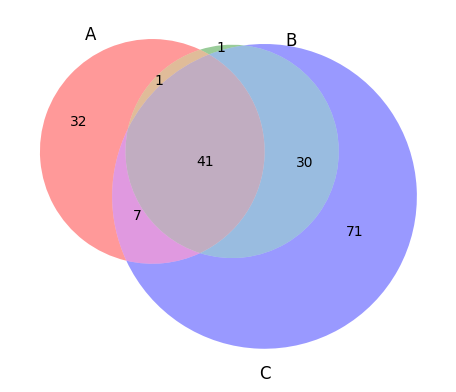

In [62]:
import matplotlib.pyplot as plt

A = all_CD_annot_cpds
B = all_PCPFM_annot_cpds_w_MS2
C = all_PCPFM_annot_cpds_wo_MS2

from matplotlib_venn import venn3
venn3([len(A.difference(B.union(C))),
      len(B.difference(A.union(C))),
      len(A.intersection(B).difference(C)),
      len(C.difference(A.union(B))),
      len(A.intersection(C).difference(B)),
      len(B.intersection(C).difference(A)),
      len(A.intersection(B).intersection(C))])
plt.show()

In [63]:
PCPFM_annots_wo_MS2 = read_pcpfm("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/Plasma_Metabolomics_HiLIC_pos/annotations/w_auth_empCpds.json")
PCPFM_annots_w_MS2 = read_pcpfm("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/Plasma_Metabolomics_HiLIC_pos/annotations/w_MS2_empCpds.json")
CD_annots = read_CD("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/manuscript_notebooks/pcpfm_vs_cd/CD_AuthenticCpds_HILIC_pos.csv")
CD_annots = map_CD_annots(CD_annots, PCPFM_annots_wo_MS2)

all_CD_annot_cpds = set()
all_PCPFM_annot_cpds_w_MS2 = set()
all_PCPFM_annot_cpds_wo_MS2 = set()

for cd_annot in CD_annots:
    for feature in cd_annot["mapped_to"]:
        all_CD_annot_cpds.add(cd_annot["Name"] + "_" + feature)

for kp_id, kp in PCPFM_annots_wo_MS2.items():
    if "identity" in kp and kp["identity"]:
        for identity in kp["identity"]:
            for peak in kp["MS1_pseudo_Spectra"]:
                id = peak['id_number']
                all_PCPFM_annot_cpds_wo_MS2.add(identity + "_" + id)
                #print(identity + "_" + id, identity + "_" + id in all_CD_annot_cpds)

for kp_id, kp in PCPFM_annots_w_MS2.items():
    if "MS2_Spectra" in kp:
        for MS2 in kp["MS2_Spectra"]:
            all_annotations = [(annotation, annotation["msms_score"]) for annotation in MS2["annotations"]]
            all_annotations = sorted(all_annotations, key=lambda x: -x[1])
            all_annotations = all_annotations[:10]
            for annotation in MS2['annotations']:
                for peak in kp["MS1_pseudo_Spectra"]:
                    #print(annotation['reference_id'] + "_" + id)
                    id = peak['id_number']
                    all_PCPFM_annot_cpds_w_MS2.add(annotation['reference_id'] + "_" + id)


CD_in_PCPFM_wo_MS2 = all_CD_annot_cpds.intersection(all_PCPFM_annot_cpds_wo_MS2)
CD_in_PCPFM_w_MS2 = all_CD_annot_cpds.intersection(all_PCPFM_annot_cpds_w_MS2)
MS2_vs_noMS2 = all_PCPFM_annot_cpds_w_MS2.intersection(all_PCPFM_annot_cpds_wo_MS2)
in_all = MS2_vs_noMS2.intersection(all_CD_annot_cpds)

print(in_all)
print("CD in PCPFM wo MS2: ", len(CD_in_PCPFM_wo_MS2))
print("CD in PCPFM w MS2: ", len(CD_in_PCPFM_w_MS2))
print("PCPFMwMS2 in PCPFMwoMS2: ", len(MS2_vs_noMS2))
print("In all 3: ", len(in_all))
print("CD Annots: ", len(all_CD_annot_cpds))
print("PCPFM w MS2: ", len(all_PCPFM_annot_cpds_w_MS2))
print("PCPFM wo MS2: ", len(all_PCPFM_annot_cpds_wo_MS2))


{'Creatine anhydrous_F4582', '1-Methyladenosine_F25682', 'Creatine anhydrous_F13058', 'Creatinine_F7243', 'Piperine_F22917', '4-Aminosalicylic acid_F5408', '4-Aminosalicylic acid_F4956', '4-Aminosalicylic acid_F6757', 'Creatinine_F7244', '4-Aminosalicylic acid_F13458', 'Piperine_F15373', 'Creatinine_F7246', '4-Aminosalicylic acid_F13944', 'Theobromine_F1092', '4-Aminosalicylic acid_F4551', 'Creatinine_F7242', 'Theobromine_F744', '1-Methyladenosine_F25185', 'Theobromine_F1520', '1-Methyladenosine_F25183', 'Creatine anhydrous_F4977', 'Piperine_F19188', 'Creatine anhydrous_F11478', 'Creatine anhydrous_F13465', '4-Aminosalicylic acid_F7220', 'Creatinine_F8051', 'Creatinine_F7245', '1-Methyladenosine_F25184', 'Creatine anhydrous_F12632', '1-Methyladenosine_F25683', 'Piperine_F15075', 'Creatinine_F7247', '4-Aminosalicylic acid_F4957', 'Theobromine_F15259', '4-Aminosalicylic acid_F5409', '4-Aminosalicylic acid_F4552'}
CD in PCPFM wo MS2:  44
CD in PCPFM w MS2:  59
PCPFMwMS2 in PCPFMwoMS2:  11

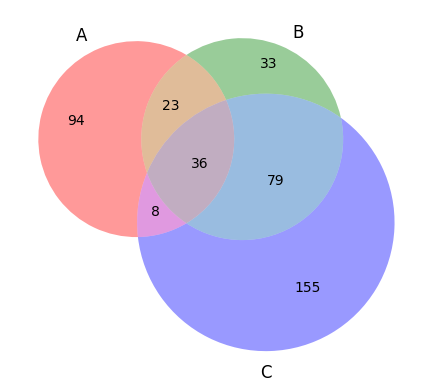

In [49]:
import matplotlib.pyplot as plt

A = all_CD_annot_cpds
B = all_PCPFM_annot_cpds_w_MS2
C = all_PCPFM_annot_cpds_wo_MS2

from matplotlib_venn import venn3
venn3([len(A.difference(B.union(C))),
      len(B.difference(A.union(C))),
      len(A.intersection(B).difference(C)),
      len(C.difference(A.union(B))),
      len(A.intersection(C).difference(B)),
      len(B.intersection(C).difference(A)),
      len(A.intersection(B).intersection(C))])
plt.show()